In [196]:
import numpy as np
import math
import matplotlib.pyplot as plt
time_step = 0.05
#currently tracks to point (2,1,1)
J = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]) #inertia tensor
L = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]) #lambda parameter
K = 2*np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]) #gain parameter

position trajectory functions 

In [197]:
def x_pos(t,x):
    return np.array([x[1], 4.0 - 3*x[1] - 2*x[0]])

def y_pos(t,y):
    return np.array([y[1], 2.0 - 3*y[1] - 2*y[0]])

def z_pos(t,z):
    return np.array([z[1], 2.0 - 3*z[1] - 2*z[0]])

In [198]:
#rk4 integrator

def rk4(func, tk, yk, dt):
    
    f1 = func(tk, yk)
    f2 = func(tk + dt / 2, yk + (f1 * (dt / 2)))
    f3 = func(tk + dt / 2, yk + (f2 * (dt / 2)))
    f4 = func(tk + dt, yk + (f3 * dt))

    return yk + (dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)


In [199]:
def trajectory_gen(time_now, present_state):
    
    x_present = [present_state[0],present_state[1]]
    y_present = [present_state[2],present_state[3]]
    z_present = [present_state[4],present_state[5]]
    time = time_now
    x_presentplusone = rk4(x_pos, time, x_present, time_step)
    y_presentplusone = rk4(y_pos, time, y_present, time_step)
    z_presentplusone = rk4(z_pos, time, z_present, time_step) 
    
    present_state[0] = x_presentplusone[0];
    present_state[1] = x_presentplusone[1];
    present_state[2] = y_presentplusone[0];
    present_state[3] = y_presentplusone[1];
    present_state[4] = z_presentplusone[0];
    present_state[5] = z_presentplusone[1];
    
    return present_state

reference velocity

In [200]:
def v_ref(present_state, quad_pos):
    present_desired_pos = [present_state[0],present_state[2],present_state[4]]
    p_d_dot = [present_state[1],present_state[3],present_state[5]]
    error = np.subtract(quad_pos, present_desired_pos)
    l = 5
    v_ref = np.subtract(p_d_dot, l*(error))
    return v_ref

attitude desired

In [201]:
def attitude_desired(present_state_derivative,q_d):
    
    X_bar = present_state_derivative[1]
    Y_bar = present_state_derivative[3]
    Z_bar = present_state_derivative[5] + 9.81
    
    Fd = np.sqrt((X_bar)**2 + (Y_bar)**2 + (Z_bar)**2)
    
    psi_d = 0
    phi_d = np.arcsin(-Y_bar/Fd)
    theta_d = np.arctan(X_bar/Z_bar)
    
    q_d[0] = theta_d
    q_d[1] = phi_d
    q_d[2] = psi_d
    return q_d

control block

In [202]:
def control(wr, wr_dot, w, u):
    
    
    cross = np.matmul(J,w)
    cross_skew = np.array([[0, -cross[2] , cross[1]],[cross[2], 0 , -cross[1]],[-cross[2], cross[1],0]])

    control_ip = np.matmul(J,wr_dot) - np.matmul(cross_skew,wr) - np.matmul(K,np.subtract(w , wr))
    
    u[0] = control_ip[0]
    u[1] = control_ip[1]
    u[2] = control_ip[2]
    return u

omega 

In [203]:
def omega(t,w):
    
    omega = w
    control_ip = u
    #print('omega')
    #print(omega)
    #print('u')
    #print(control_ip)
    cross = np.matmul(J,omega)
    cross_skew = np.array([[0, -cross[2] , cross[1]],[cross[2], 0 , -cross[1]],[-cross[2], cross[1],0]])
    dw = np.matmul(cross_skew , omega) + control_ip
    return dw

attitude q

In [204]:
def attitude(tk,q):
    
    theta = q[0]
    phi = q[1]
    psi = q[2]
    att = np.array([theta,phi,psi])
    omega = np.array([w[0],w[1],w[2]])
    Z_q = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],[0, np.cos(phi), -1*np.sin(phi)],[0, np.sin(phi)*(1/np.cos(theta)),np.cos(phi)*(1/np.cos(theta))]])
    
    dq = np.matmul(Z_q,omega)
    dq = np.array([dq[0],dq[1],dq[2]])
    return dq

reference omega

In [205]:
def ref_omega(q,q_d,q_ddot):
    
    theta = q[0]
    phi = q[1]
    psi = q[2]
    att = np.array([theta,phi,psi])
    omega_r = np.array([0,0,0])
    Z_q = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],[0, np.cos(phi), -1*np.sin(phi)],[0, np.sin(phi)*(1/np.cos(theta)),np.cos(phi)*(1/np.cos(theta))]])
    Z_q_inv = np.linalg.inv(Z_q)
   
    omega_r = np.matmul(Z_q_inv, q_ddot) + np.matmul(Z_q_inv, np.matmul(L,np.subtract(q_d,att)))
    

    return omega_r

position dynamics

In [208]:
def delay(time_delay):
    count = 0
    while (count<time_delay):
        count = count+1

In [231]:
initial_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0]) #position and velocity
present_state = initial_state
prev_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0])

prev_qd = np.array([0.0,0.0,0.0]) #euler angles
q_d = np.array([0.0,0.0,0.0]) #desired attitude
q_state = np.array([0.0,0.0,0.0])
q = np.array([0.0,0.0,0.0])

w = np.array([0.0,0.0,0.0]) #omega
wr = np.array([0.0,0.0,0.0])
prev_wr = np.array([0.0,0.0,0.0])
wr_dot = np.array([0.0,0.0,0.0])

u = np.array([0.0,0.0,0.0])

vr_prev = np.array([0.0,0.0,0.0])
vr = np.array([0.0,0.0,0.0])
quad_pos = np.array([0.0,0.0,0.0])
quad_vel = np.array([0.0,0.0,0.0])
acc_ip = np.array([0.0,0.0,0.0])

quad_acc = np.array([0.0,0.0,0.0])
tsp = np.array([0.0,0.0,0.0])
pos = np.array([0.0,0.0,0.0])
vel = np.array([0.0,0.0,0.0])
quad_pos_state = np.zeros((600,3),dtype = np.float64)

time_now = 0
ele = 0
while time_now < 30:
    time_now = time_now + time_step
    
    prev_state = present_state
    
    #desired trajectory calculation/input from path planner
    present_state = trajectory_gen(time_now, present_state)
    present_state_derivative = np.subtract(present_state , prev_state)/time_step
    vr = v_ref(present_state, quad_pos) 
    vr_dot = np.subtract(vr,vr_prev)/time_step
    Kv = 0.125
    acc_ip = -Kv*(np.subtract(quad_vel,vr)) + vr_dot
    vr_prev = vr
    
    #finding desired attitude from the trajectory
    prev_qd = q_d
    #q_d = attitude_desired(quad_acc,q_d)
    X_bar = acc_ip[0]
    Y_bar = acc_ip[1]
    Z_bar = acc_ip[2] + 9.81
    
    Fd = np.sqrt((X_bar)**2 + (Y_bar)**2 + (Z_bar)**2)
    
    psi_d = 0
    phi_d = np.arcsin(-Y_bar/Fd)
    theta_d = np.arctan(X_bar/Z_bar)
    
    q_d[0] = theta_d
    q_d[1] = phi_d
    q_d[2] = psi_d
    tsp = [0.0,0.0,Fd]
    
    q_ddot = np.subtract(q_d , prev_qd)/time_step   
    
    #finding reference omega values
    prev_wr = wr
    wr = ref_omega(q,q_d,q_ddot)
    wr_dot = np.subtract(wr,prev_wr)/time_step
    
    u = control(wr,wr_dot,w,u)
    
    w = rk4(omega,time_now,w,time_step)
    
    q = rk4(attitude,time_now,q,time_step) 
    theta = q[0]
    phi = q[1]
    psi = q[2]
    Z_q = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],[0, np.cos(phi), -1*np.sin(phi)],[0, np.sin(phi)*(1/np.cos(theta)),np.cos(phi)*(1/np.cos(theta))]])
    tf = [0.0,0.0,-9.81] + np.matmul(Z_q,tsp)
    vel = vel + tf*time_step
    quad_vel = vel
    pos = pos + quad_vel*time_step
    quad_pos = pos
    
    quad_pos_state[ele] = quad_pos
    ele = ele + 1
    

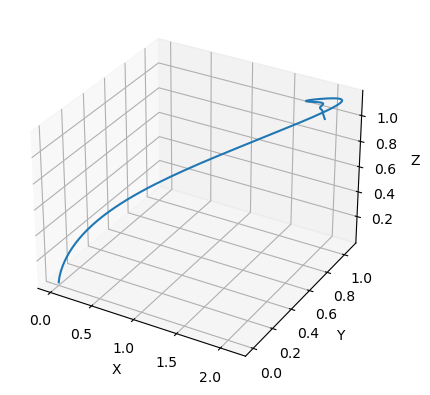

In [232]:
fig = plt.figure()
ax = plt.axes(projection='3d')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot3D(quad_pos_state[:,0],quad_pos_state[:,1],quad_pos_state[:,2])
plt.show()

In [233]:
print(quad_pos_state)

[[5.56151632e-04 2.71011010e-04 6.89044038e-03]
 [2.14387651e-03 1.04483485e-03 1.96094350e-02]
 [5.16630655e-03 2.51821869e-03 3.72006874e-02]
 ...
 [1.99715185e+00 9.98468134e-01 1.00836209e+00]
 [1.99716942e+00 9.98477585e-01 1.00831017e+00]
 [1.99718689e+00 9.98486979e-01 1.00825857e+00]]
